In [1]:
import os
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
import IPython.display as ipd
import glob
import h5py
import plotly.graph_objs as go
import plotly.express as px
from PIL import Image
from tempfile import mktemp

from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.models.tools import HoverTool
from bokeh.palettes import BuGn4
from bokeh.plotting import figure, output_notebook, show
from bokeh.transform import cumsum
from math import pi

output_notebook()

from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image

Loading BokehJS ...

In [2]:
print(os.listdir('../input/landmark-recognition-2020/'))

['train', 'test', 'sample_submission.csv', 'train.csv']


In [3]:
BASE_PATH = '../input/landmark-recognition-2020'

TRAIN_DIR = f'{BASE_PATH}/train'
TEST_DIR = f'{BASE_PATH}/test'

print('Reading data...')
train = pd.read_csv(f'{BASE_PATH}/train.csv')
sub = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
print('Reading data completed')

Reading data...
Reading data completed


In [4]:
train.head()

id  landmark_id
0  17660ef415d37059            1
1  92b6290d571448f6            1
2  cd41bf948edc0340            1
3  fb09f1e98c6d2f70            1
4  25c9dfc7ea69838d            7

In [5]:
sub.head()

id   landmarks
0  00084cdf8f600d00  137790 0.1
1  000b15b043eb8cf0  137790 0.1
2  0011a52f9b948fd2  137790 0.1
3  00141b8a5a729084  137790 0.1
4  0018aa4b92532b77  137790 0.1

In [6]:
train.shape[0]

1580470

In [7]:
sub.shape

(10345, 2)

In [8]:
landmarks = len(train['landmark_id'].unique())
landmarks

81313

In [9]:
print('Top few landmark_ids by count')

z = train.landmark_id.value_counts().head(10).to_frame()
z.reset_index(inplace=True)
z.columns=['landmark_id','count']
z.landmark_id = z.landmark_id.apply(lambda x: f'id_{x}')

z.style.background_gradient(cmap='Oranges')

Top few landmark_ids by count


In [10]:
# displaying only top 30 landmark
landmark = train.landmark_id.value_counts()
landmark_df = pd.DataFrame({'landmark_id':landmark.index, 'frequency':landmark.values}).head(30)

landmark_df['landmark_id'] =   landmark_df.landmark_id.apply(lambda x: f'landmark_id_{x}')

fig = px.bar(landmark_df, x="frequency", y="landmark_id",color='landmark_id', orientation='h',
             hover_data=["landmark_id", "frequency"],
             height=1000,
             title='Number of images per landmark_id (Top 30 landmark_ids)')
fig.show()

In [11]:
import PIL
from PIL import Image, ImageDraw


def display_images(images, title=None): 
    f, ax = plt.subplots(5,5, figsize=(18,22))
    if title:
        f.suptitle(title, fontsize = 30)

    for i, image_id in enumerate(images):
        image_path = os.path.join(TRAIN_DIR, f'{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg')
        image = Image.open(image_path)
        
        ax[i//5, i%5].imshow(image) 
        image.close()       
        ax[i//5, i%5].axis('off')

        landmark_id = train[train.id==image_id.split('.')[0]].landmark_id.values[0]
        ax[i//5, i%5].set_title(f"ID: {image_id.split('.')[0]}\nLandmark_id: {landmark_id}", fontsize="12")

    plt.show() 

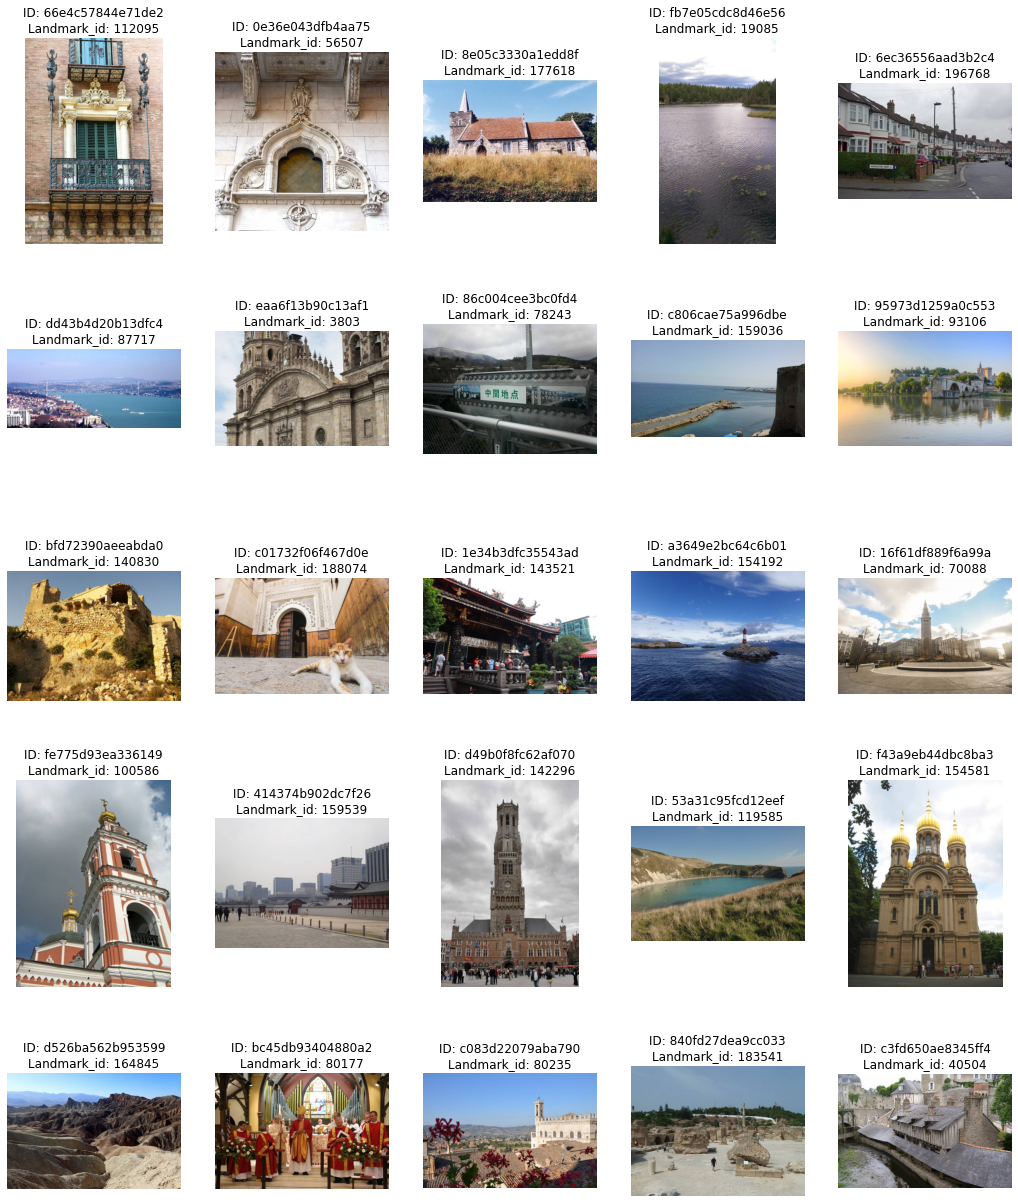

In [12]:
samples = train.sample(25).id.values
display_images(samples)

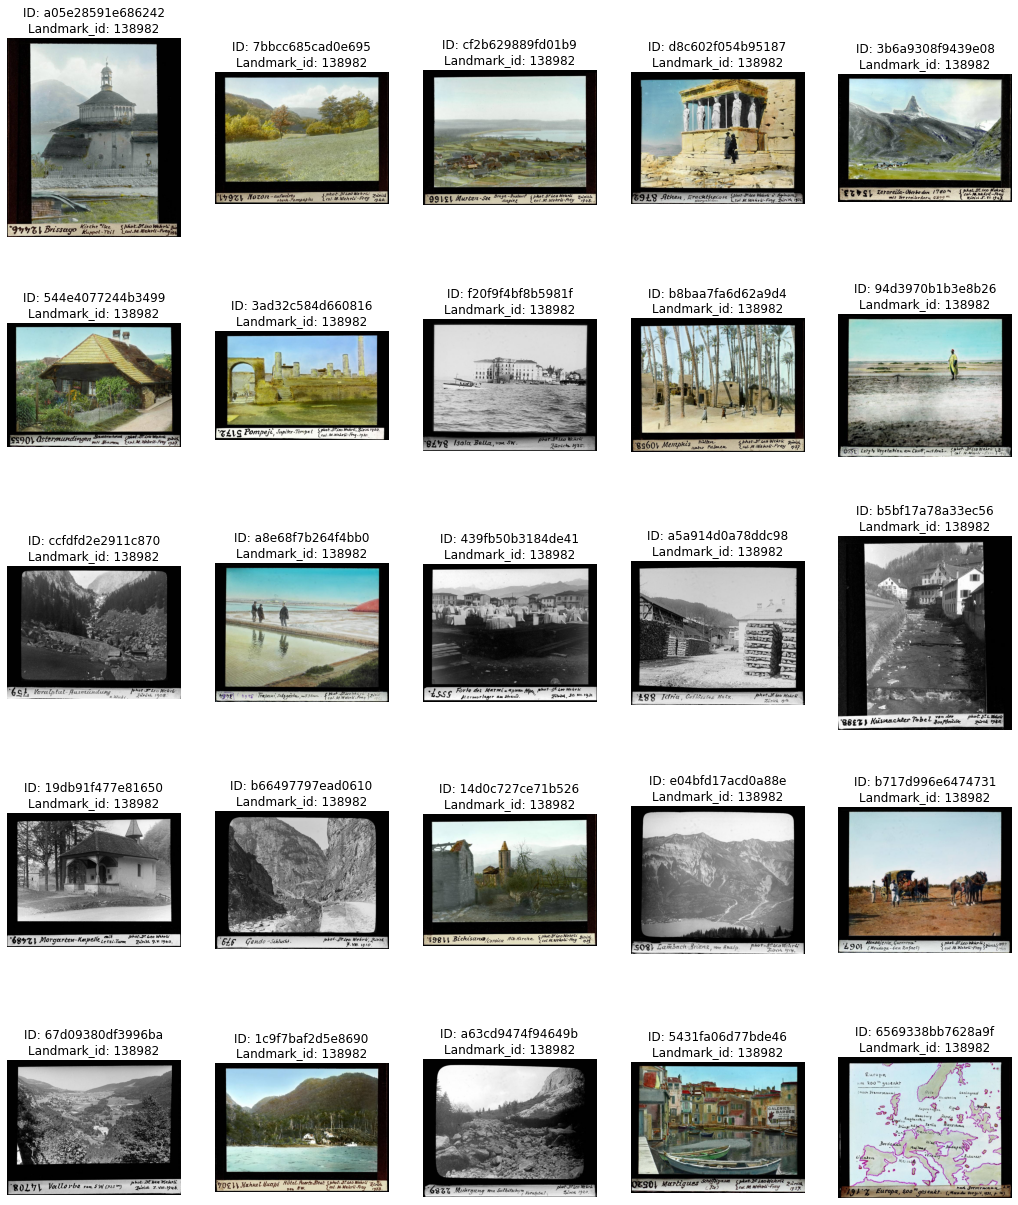

In [13]:
samples = train[train.landmark_id == 138982].sample(25).id.values
display_images(samples)

## Most Occuring Landmarks

In [14]:
from collections import Counter
landmark_counts = dict(Counter(train['landmark_id']))
landmark_dict = {'landmark_id': list(landmark_counts.keys()), 'count': list(landmark_counts.values())}

landmark_count_df = pd.DataFrame.from_dict(landmark_dict)
landmark_count_sorted = landmark_count_df.sort_values('count', ascending = False)
landmark_count_sorted.head(20)

landmark_id  count
55807       138982   6272
50843       126637   2231
8211         20409   1758
33462        83144   1741
45494       113209   1135
71194       177870   1088
77976       194914   1073
60095       149980    971
56171       139894    966
750           1924    944
70646       176528    920
3647          9070    900
18876        46705    888
67271       168098    888
8098         20120    888
64819       161902    861
14891        36748    839
48476       120734    820
70458       176018    820
4187         10419    776

## Distribution of Landmarks with their counts

In [15]:
fig_count = px.histogram(landmark_count_df, x = 'landmark_id', y = 'count')
fig_count.update_layout(
    title_text='Distribution of Landmarks',
    xaxis_title_text='Landmark ID',
    yaxis_title_text='Count'
)

fig_count.show()

# Pre-trained models

In [17]:
from tensorflow.keras.applications import(
                vgg16,
                resnet50,
                mobilenet,
                inception_v3)

In [18]:
vgg_model = vgg16.VGG16(weights = 'imagenet')

553467904/553467096 [==============================] - 12s 0us/step


In [19]:
resnet_model = resnet50.ResNet50(weights = 'imagenet')

102973440/102967424 [==============================] - 2s 0us/step


In [20]:
mobilenet_model = mobilenet.MobileNet(weights = 'imagenet') 

17227776/17225924 [==============================] - 1s 0us/step


In [21]:
train_list = glob.glob('../input/landmark-recognition-2020/train/*/*/*/*')
test_list = glob.glob('../input/landmark-recognition-2020/test/*/*/*/*')

In [22]:
train_list

['../input/landmark-recognition-2020/train/9/9/9/9999d1ac6d856730.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/9997353fa49a7504.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999ba937542d1885.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/9996a84862f270c4.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/9994c11573685c3e.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999655eac8e43c66.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999cbbf9c5be2ccb.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999c24319dce861e.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999d7e6e56b11fa6.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999d3619dfd031cb.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999277c6e1e9c24e.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999c3d1aa2543ea8.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999132ef5ded0a4f.jpg',
 '../input/landmark-recognition-2020/train/9/9/9/999c270f3387c2c

In [23]:
test_list

['../input/landmark-recognition-2020/test/9/9/9/999dceaeeed8caf9.jpg',
 '../input/landmark-recognition-2020/test/9/9/c/99c1b59fa3b43846.jpg',
 '../input/landmark-recognition-2020/test/9/9/7/997d94815bea827d.jpg',
 '../input/landmark-recognition-2020/test/9/9/7/997a84232ec25a53.jpg',
 '../input/landmark-recognition-2020/test/9/9/7/997c27d50203cf68.jpg',
 '../input/landmark-recognition-2020/test/9/9/7/997f68d90399dbe0.jpg',
 '../input/landmark-recognition-2020/test/9/9/d/99df7b13c6b2e3b3.jpg',
 '../input/landmark-recognition-2020/test/9/9/d/99d828f113b39fcb.jpg',
 '../input/landmark-recognition-2020/test/9/9/d/99d6c91917497fe5.jpg',
 '../input/landmark-recognition-2020/test/9/9/d/99d6dac0f0456c5a.jpg',
 '../input/landmark-recognition-2020/test/9/9/2/9922af16376053a2.jpg',
 '../input/landmark-recognition-2020/test/9/9/f/99f85b00dc2aba78.jpg',
 '../input/landmark-recognition-2020/test/9/9/f/99f07292ea173d63.jpg',
 '../input/landmark-recognition-2020/test/9/9/8/9982ce8b49b9aff4.jpg',
 '../i

In [24]:
filename = '../input/landmark-recognition-2020/train/1/1/1/11172998c813fe6f.jpg'

# VGG16

PIL image size (224, 224)


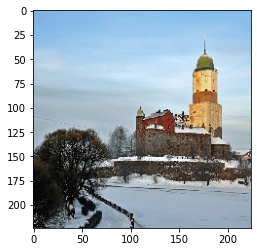

In [25]:
original = image.load_img(filename,target_size=(224,224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()

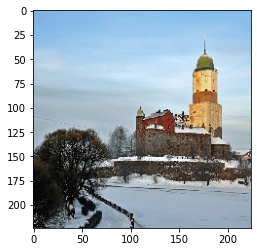

numpy array size (224, 224, 3)


In [26]:
from tensorflow.keras.preprocessing.image import img_to_array
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)

image batch size (1, 224, 224, 3)


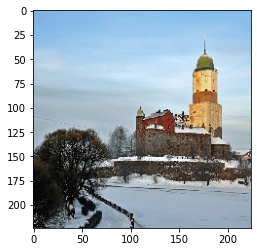

In [27]:
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [28]:
# prepare the image for the VGG model
from keras.applications.imagenet_utils import decode_predictions
processed_image = vgg16.preprocess_input(image_batch.copy())
# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image)
# print predictions
# convert the probabilities to class labels
# we will get top 5 predictions which is the default
label_vgg = decode_predictions(predictions)
# print VGG16 predictions
for prediction_id in range(len(label_vgg[0])):
    print(label_vgg[0][prediction_id])


40960/35363 [==================================] - 0s 0us/step
('n02980441', 'castle', 0.78940326)
('n03781244', 'monastery', 0.041827865)
('n03877845', 'palace', 0.03904378)
('n02814860', 'beacon', 0.030839667)
('n03028079', 'church', 0.023079986)


# ResNet50

In [29]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

In [30]:
img = image.load_img(filename,target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)
img = preprocess_input(img)

In [31]:
preds = resnet_model.predict(img)

In [32]:
print( decode_predictions(preds, top=1)[0])

[('n02980441', 'castle', 0.5708064)]


# MobileNet 

In [33]:
pred = mobilenet_model.predict(img)
print(decode_predictions(pred))

[[('n03598930', 'jigsaw_puzzle', 0.5179142), ('n04346328', 'stupa', 0.1176623), ('n02980441', 'castle', 0.074412), ('n02814860', 'beacon', 0.053380266), ('n03877845', 'palace', 0.04246764)]]
